In [68]:
%matplotlib inline

from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import StratifiedKFold
# from sklearn.base import clone

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']
display(X.shape)
display(y.shape)

(70000, 784)

(70000,)

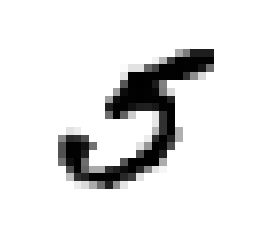

In [4]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [8]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [9]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict(some_digit.reshape(1, -1))

array([False])

In [11]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." %

array([0.954  , 0.96435, 0.9262 ])

In [12]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90725, 0.9132 , 0.9085 ])

In [14]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." %

In [15]:
confusion_matrix(y_train_5, y_train_pred)

array([[52288,  2291],
       [  818,  4603]], dtype=int64)

In [16]:
precision_score(y_train_5, y_train_pred)

0.6676820423556716

In [17]:
recall_score(y_train_5, y_train_pred)

0.8491053311197196

In [18]:
f1_score(y_train_5, y_train_pred)

0.7475436459602112

In [19]:
display(sgd_clf.decision_function([X[0]]))
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-535999.11583547])

array([-109044.24223125])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." %

In [22]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

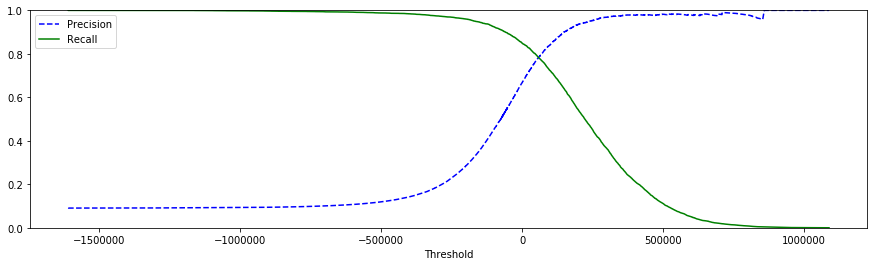

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    
plt.figure(figsize=(15, 4))    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)    
plt.show()    

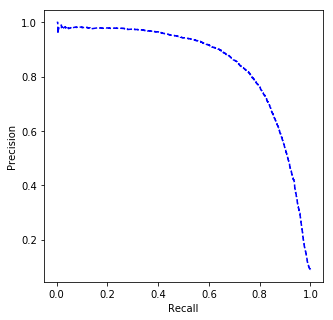

In [35]:
plt.figure(figsize=(5, 5))  
plt.plot(recalls[:-1], precisions[:-1], "b--", label="Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show() 

In [25]:
y_train_pred_90 = (y_scores>70000)

In [26]:
precision_score(y_train_5, y_train_pred_90)

0.8014238984029247

In [27]:
recall_score(y_train_5, y_train_pred_90)

0.7683084301789338

In [29]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

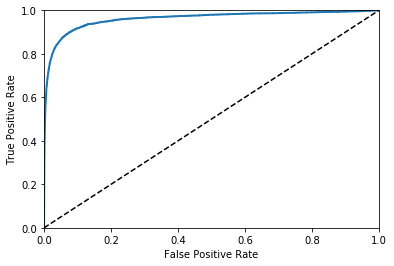

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores)

0.9617213999751831

In [37]:
rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [42]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

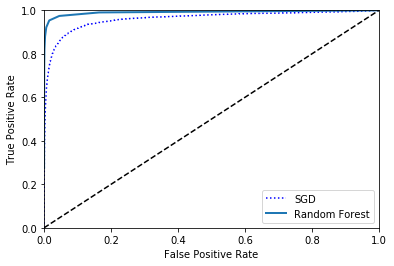

In [43]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9913126490296459

In [45]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

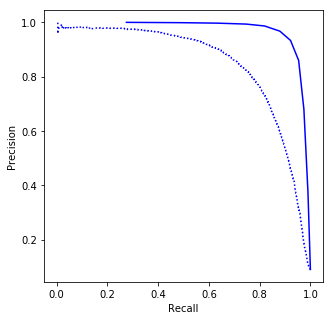

In [49]:
plt.figure(figsize=(5, 5))  
plt.plot(recalls[:-1], precisions[:-1], "b:", label="SGD")
plt.plot(recalls_forest[:-1], precisions_forest[:-1], "b-", label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show() 

In [57]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([5.])

In [58]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-135308.34084816, -399199.75500916, -320828.79487953,
        -106505.87047718, -158898.23660635,   64498.5624994 ,
        -792839.00951588, -160675.01413263, -755900.40122889,
        -598361.12496656]])

In [62]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [63]:
len(ovo_clf.estimators_)

45

In [64]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [65]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0.1, 0.7, 0. , 0. , 0. , 0. ]])

In [66]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='accuracy')

array([0.84972928, 0.86285619, 0.8885    , 0.88088689, 0.83736245])

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90556889, 0.9119956 , 0.91368705])

In [71]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5729,    2,   22,    9,   12,   46,   50,    8,   42,    3],
       [   1, 6481,   45,   22,    6,   36,    6,   12,  124,    9],
       [  52,   37, 5345,  101,   78,   21,   97,   53,  154,   20],
       [  45,   43,  136, 5322,    3,  256,   36,   54,  136,  100],
       [  21,   26,   36,   11, 5379,    9,   53,   31,   86,  190],
       [  66,   40,   33,  189,   76, 4596,  104,   24,  190,  103],
       [  33,   25,   40,    3,   40,   88, 5634,    4,   51,    0],
       [  24,   25,   72,   26,   55,   13,    6, 5794,   18,  232],
       [  47,  146,   73,  149,   13,  153,   55,   27, 5056,  132],
       [  41,   32,   29,   87,  171,   31,    2,  202,   78, 5276]],
      dtype=int64)

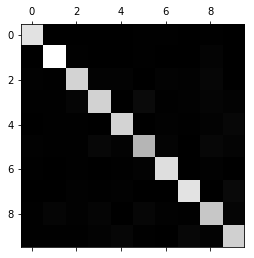

In [72]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

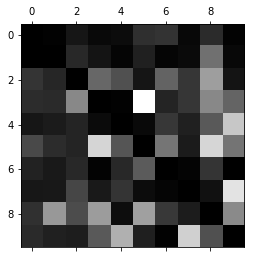

In [76]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()